### Train Classifier
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import pickle

from collections import Counter
import itertools
from dbfread import DBF
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
#from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

### Clean and Process Data

##### Needed Features:
* Age
    * Continuous
* Household Income  
    * 49,999 or less
    * 50,000 to 74,999
    * 75,000
    * Don't Know / Refused
* Gender
    * Male
    * Female
* Car Sufficiency
    * Zero Cars
    * Fewer Cars than Workers
    * Cars Equal to Workers
    * More Cars than Workers
* Education Level
    * Bachelors or Higher
    * Less than Bachelors
    * Don't Know / Refused
* Job Industry
    * Agriculture and Mining
    * Transportation, Utilities and Warehousing
    * Manufacturing and Wholesale Trade
    * Information, Professor/Scientist, Management, Admin
    * Education
    * Finance & Real Estate
    * Arts/Entertainment
    * Public Admin
    * Health
    * Other
    * MORPC INDUS=80
    * Retail
* Multiple Jobs
    * One Job
    * More than One Job
    * No Job
    * Don't Know / Refused
* Accesibility
    * Zero Cars
    * Fewer Cars than Workers
    * Equal or More Cars than Workers
* Distance to Work/School

In [3]:
# Import data
idap_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/IDAP.dbf')
idap = pd.DataFrame(iter(idap_dbf))

hhtype_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/hhtype.dbf')
hhtype = pd.DataFrame(iter(hhtype_dbf))

pertype_dbf = DBF('R:/Projects/20713A_Ohio3C/HIS/PERTYPE.dbf')
pertype = pd.DataFrame(iter(pertype_dbf))

accessibility_dbf = DBF('R:/Projects/20713A_Ohio3C/Accessibility/ACCESSIBILITY_MEASURES.dbf')
accessibility = pd.DataFrame(iter(accessibility_dbf))


In [4]:
# Process IDAP Data
idap = idap[idap['MPO'] == 1]
    
genders = {1:'Male', 2:'Female'}
pertypes = {1:'FT_Worker', 2:'PT_Worker', 3:'Univ_Stud', 4:'Non_Worker', 5:'Retiree', 6:'DA_Stud', 7:'PDA_Stud', 8:'PreSch_Child'}
idaps = {1:'M', 2:'NM', 3:'H'}

idap['GENDER'] = idap.GENDER.map(genders)
idap['PERTYPE'] = idap.PERTYPE.map(pertypes)
idap['IDAP'] = idap.IDAP.map(idaps)
idap.age = idap.AGE.astype(int)

idap = idap[['SAMPN', 'PERNO', 'GENDER', 'PERTYPE', 'AGE', 'IDAP']]
idap.dropna(inplace=True)


In [5]:
# Process household type data
hhtype = hhtype[hhtype['MPO'] == 1]

incomes = {1: '$49,999 or less', 2: '$49,999 or less', 3: '$50,000 to $74,999', 4: '$75,000 or more', \
           5: '$75,000 or more', 9: 'DK/RF'}
hhtype['HINCCAT1'] = hhtype.HINCCAT1.map(incomes)
hhtype['HWORK_F'] = hhtype['HWORK_F'].fillna(0)
hhtype['HWORK_P'] = hhtype['HWORK_P'].fillna(0)
hhtype['WORKERS'] = hhtype['HWORK_F'] + hhtype['HWORK_P']
           
    
# Calculate car sufficiency
car_sufficiency = []
for ix, row in hhtype.iterrows():
    if row['HHVEH'] == 0:
        car_sufficiency.append('Zero Cars')
    elif row['HHVEH'] < row['WORKERS']:
        car_sufficiency.append('Fewer Cars than Workers')
    elif row['HHVEH'] == row['WORKERS']:
        car_sufficiency.append('Cars Equals to Workers')
    elif row['HHVEH'] > row['WORKERS']:
        car_sufficiency.append('More Cars than Workers')
        
hhtype['CAR_SUFF'] = car_sufficiency


hh_features = hhtype[['SAMPN', 'CAR_SUFF', 'HINCCAT1', 'HHTAZ']]

In [6]:
# Process person type data
pertype = pertype[pertype['MPO'] == 1]
educations = {1: 'Less than Bachelors', 2: 'Less than Bachelors', 3: 'Less than Bachelors', \
              4: 'Less than Bachelors', 5: 'Bachelors or Higher Degree', 6: 'Bachelors or Higher Degree', \
              7: 'Less than Bachelors', 99: 'DK/RF'}

numjobs = {0: 'No Job', 1: 'More than One Job', 2: 'One Job', 99: 'DK/RF'}
jobtypes = {1: 'Agriculture and Mining', 2: 'Transportation, Utilities and Warehousing', \
            3: 'Manufacturing and Wholesale Trade', 5: 'Information, Professor/Scientist, Management, Admin', \
            6: 'Education', 7: 'Finance & Real Estate', 8: 'Arts/Entertainment', 9: 'Public Admin', \
            10: 'Health', 11: 'Other', 12: 'MORPC INDUS=80', 13: 'Retail'}


pertype.EDUCA = pertype.EDUCA.map(educations)
pertype.JOBS = pertype.JOBS.map(numjobs)
pertype.JOBTYPE = pertype.JOBTYPE.map(jobtypes)
pertype.JOBTYPE = pertype.JOBTYPE.fillna('No Job Type')
per_features = pertype[['SAMPN', 'PERNO', 'EDUCA', 'JOBS', 'JOBTYPE', 'WU_DIST', 'SU_DIST']]

In [7]:
# Process accessibility data
accessibility = accessibility[accessibility['MPO'] == 1]
access_features = accessibility[['TAZ', 'ACCESS7', 'ACCESS8', 'ACCESS9']]

In [8]:
idap.reset_index(inplace=True)
idap['PERID'] = idap['SAMPN'].astype(str) + idap['PERNO'].astype(str)
per_features['PERID'] = per_features['SAMPN'].astype(str) + per_features['PERNO'].astype(str)

In [9]:
# Merge household data
features = pd.merge(idap, hh_features, on='SAMPN', how='inner')
features = pd.merge(features, per_features, on='PERID', how='inner')
features = pd.merge(features, access_features, left_on='HHTAZ', right_on='TAZ', how='left')
features.drop(['PERNO_y', 'TAZ', 'SAMPN_y', 'HHTAZ', 'index'], axis=1, inplace=True)

In [10]:
# Assign accessibilities
accessibility = []
for ix, row in features.iterrows():
    if row['CAR_SUFF'] == 'Zero Cars':
        accessibility.append(row['ACCESS7'] + 1)
    elif row['CAR_SUFF'] == 'Fewer Cars Than Workers':
        accessibility.append(row['ACCESS8'] + 1)
    else:
        accessibility.append(row['ACCESS9'] + 1)
features['ACCESSIBILITY'] = np.log(accessibility)
features.drop(['ACCESS7', 'ACCESS8', 'ACCESS9'], axis=1, inplace=True)

In [11]:
# Assign work or school distance based on person type
distances = []
for ix, row in features.iterrows():
    if row['PERTYPE'] == 'FT_Worker' or row['PERTYPE'] == 'PT_Worker':
        distances.append(row['WU_DIST'])
    else:
        distances.append(row['SU_DIST'])
        
features['DIST'] = distances
features.drop(['WU_DIST', 'SU_DIST', 'PERID'], axis=1, inplace=True)
features.head()

,SAMPN_x,PERNO_x,GENDER,PERTYPE,AGE,IDAP,CAR_SUFF,HINCCAT1,EDUCA,JOBS,JOBTYPE,ACCESSIBILITY,DIST
0,11002042,1,Female,Retiree,71,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,13.659632,0.00
1,11003319,1,Male,FT_Worker,57,M,More Cars than Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.652378,3.99
2,11003319,2,Female,PT_Worker,54,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,One Job,Education,13.652378,1.65
3,11003319,3,Male,DA_Stud,19,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,More than One Job,Retail,13.652378,1.36
4,11003959,1,Male,FT_Worker,40,M,Cars Equals to Workers,"$49,999 or less",Bachelors or Higher Degree,One Job,Retail,13.562480,16.54


### Split Data by Person Type and Create Dependent and Independent Features

In [12]:
# Split into X and Y by person type
for person_type in features.PERTYPE.unique():
    df = features[features['PERTYPE'] == person_type]
    globals()['X_%s' % person_type] = df.drop(['SAMPN_x', 'PERNO_x', 'IDAP'], axis=1)
    globals()['X_%s' % person_type] = pd.get_dummies(globals()['X_%s' % person_type])
    globals()['Y_%s' % person_type] = df['IDAP']

In [13]:
# Split data into train and test for each person type
for person_type in features.PERTYPE.unique():
    globals()['X_train_%s' % person_type], globals()['X_test_%s' % person_type], globals()['Y_train_%s' % person_type], globals()['Y_test_%s' % person_type] = train_test_split(globals()['X_%s' % person_type], globals()['Y_%s' % person_type], test_size=1/3, stratify=globals()['Y_%s' % person_type], \
                                                        random_state=234)

In [14]:
# Upsample to balance out classes
sm = SMOTE(random_state=12, ratio = 1.0)
for person_type in features.PERTYPE.unique():
    globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type] = sm.fit_sample(globals()['X_train_%s' % person_type], globals()['Y_train_%s' % person_type])
    globals()['X_train_res_%s' % person_type] = pd.DataFrame(globals()['X_train_res_%s' % person_type], columns=globals()['X_train_%s' % person_type].columns)
### NEED TO FIX CATEGORICAL FEATURES TO INT ###

In [15]:
# Define confusion matrix plot function
class_names = ['H', 'M', 'NM']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    print ()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Evaluate Machine Learning Models

##### Decision Tree

In [76]:
# Define scoring metric to optmize model parameters
f1_scorer = make_scorer(f1_score, average='weighted')

In [102]:
# Find optimal max depth parameter
param_grid = {'max_depth': np.linspace(3,40,30)}
dtc = DTC(random_state=123)
for person_type in features.PERTYPE.unique():
    globals()['dt_model_%s' % person_type] = GridSearchCV(dtc, param_grid, scoring=f1_scorer)
    globals()['dt_model_%s' % person_type].fit(globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type])
    print (person_type + ' {}'.format(globals()['dt_model_%s' % person_type].best_params_))

Retiree {'max_depth': 17.03448275862069}
FT_Worker {'max_depth': 22.137931034482762}
PT_Worker {'max_depth': 19.586206896551726}
DA_Stud {'max_depth': 11.931034482758621}
PreSch_Child {'max_depth': 3.0}
PDA_Stud {'max_depth': 18.310344827586206}
Non_Worker {'max_depth': 15.758620689655174}
Univ_Stud {'max_depth': 8.1034482758620694}


In [103]:
# Cross validate using best parameters
avg_acc = []
for person_type in features.PERTYPE.unique():
    for i in range(100,125):
        X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                      globals()['Y_%s' % person_type], \
                                                                      test_size=0.33, random_state=i, \
                                                            stratify=globals()['Y_%s' % person_type])

        Y_pred = globals()['dt_model_%s' % person_type].predict(X_test)
        avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print (person_type + " F1 Score: {}%".format(np.mean(avg_acc)*100))

Retiree F1 Score: 81.9246924829228%
FT_Worker F1 Score: 85.70915490842357%
PT_Worker F1 Score: 84.95311957360786%
DA_Stud F1 Score: 84.63423953623366%
PreSch_Child F1 Score: 78.96464852275946%
PDA_Stud F1 Score: 80.7484177498502%
Non_Worker F1 Score: 80.63491888176772%
Univ_Stud F1 Score: 79.75998822084152%


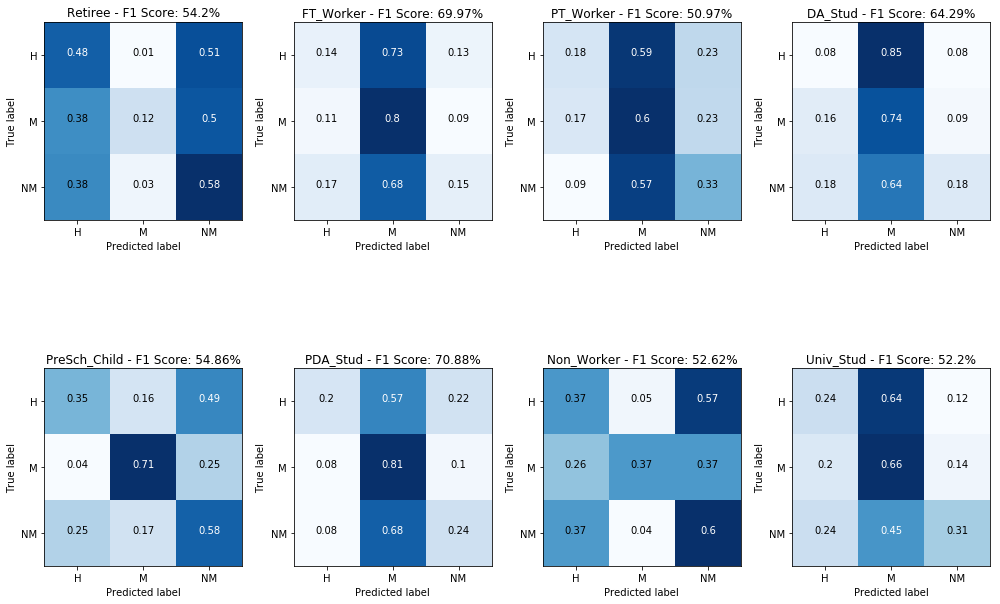

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for person_type, ax in zip(features.PERTYPE.unique(), axes):
    Y_pred = globals()['dt_model_%s' % person_type].predict(globals()['X_test_%s' % person_type])
    cm = confusion_matrix(globals()['Y_test_%s' % person_type], Y_pred)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(person_type + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(globals()['Y_test_%s' % person_type], Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##### Random Forest

In [105]:
# Find optimal max depth and criterion parameter
param_grid = {'max_depth': np.linspace(5,40,15), 'criterion': ['gini', 'entropy']}
rfc = RFC(random_state=123, n_jobs=-1, n_estimators=50)
for person_type in features.PERTYPE.unique():
    globals()['rf_model_%s' % person_type] = GridSearchCV(rfc, param_grid, scoring=f1_scorer)
    globals()['rf_model_%s' % person_type].fit(globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type])
    print (person_type + ' {}'.format(globals()['rf_model_%s' % person_type].best_params_))

Retiree {'criterion': 'entropy', 'max_depth': 15.0}
FT_Worker {'criterion': 'entropy', 'max_depth': 32.5}
PT_Worker {'criterion': 'gini', 'max_depth': 15.0}
DA_Stud {'criterion': 'entropy', 'max_depth': 15.0}
PreSch_Child {'criterion': 'gini', 'max_depth': 5.0}
PDA_Stud {'criterion': 'entropy', 'max_depth': 17.5}
Non_Worker {'criterion': 'gini', 'max_depth': 20.0}
Univ_Stud {'criterion': 'entropy', 'max_depth': 17.5}


In [106]:
# Cross validate using best parameters
avg_acc = []
for person_type in features.PERTYPE.unique():
    for i in range(100,125):
        X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                      globals()['Y_%s' % person_type], \
                                                                      test_size=0.33, random_state=i, \
                                                            stratify=globals()['Y_%s' % person_type])

        Y_pred = globals()['rf_model_%s' % person_type].predict(X_test)
        avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print (person_type + " F1 Score: {}%".format(np.mean(avg_acc)*100))

Retiree F1 Score: 82.60953084632791%
FT_Worker F1 Score: 87.75271766396284%
PT_Worker F1 Score: 86.90754380241059%
DA_Stud F1 Score: 88.04506615272051%
PreSch_Child F1 Score: 82.5733353905175%
PDA_Stud F1 Score: 84.00365047568906%
Non_Worker F1 Score: 84.13961422418359%
Univ_Stud F1 Score: 84.38050785217732%


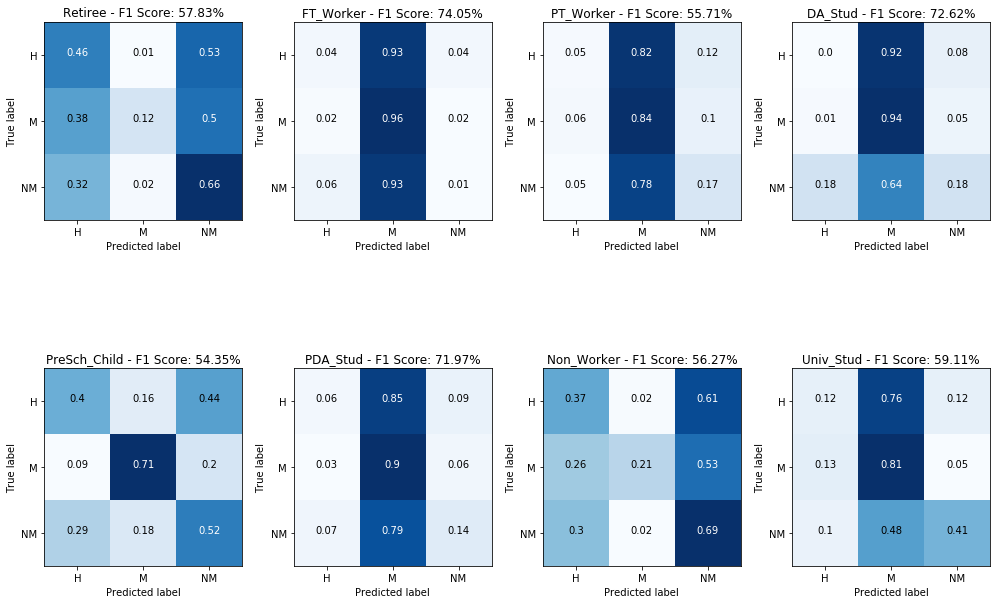

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for person_type, ax in zip(features.PERTYPE.unique(), axes):
    Y_pred = globals()['rf_model_%s' % person_type].predict(globals()['X_test_%s' % person_type])
    cm = confusion_matrix(globals()['Y_test_%s' % person_type], Y_pred)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(person_type + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(globals()['Y_test_%s' % person_type], Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##### Artificial Neural Network

In [108]:
# Find optimal hidden layers and activation parameters
param_grid = {'hidden_layer_sizes': [(14), (21), (14,7), (21,14), (14,28,21), (14,21,14)], \
              'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp = MLPClassifier(random_state=123)
for person_type in features.PERTYPE.unique():
    globals()['mlp_model_%s' % person_type] = GridSearchCV(mlp, param_grid, scoring=f1_scorer)
    globals()['mlp_model_%s' % person_type].fit(globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type])
    print (person_type + ' {}'.format(globals()['mlp_model_%s' % person_type].best_params_))

Retiree {'activation': 'tanh', 'hidden_layer_sizes': (14, 28, 21)}
FT_Worker {'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}
PT_Worker {'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}
DA_Stud {'activation': 'tanh', 'hidden_layer_sizes': (14, 21, 14)}
PreSch_Child {'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}
PDA_Stud {'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}
Non_Worker {'activation': 'tanh', 'hidden_layer_sizes': (21, 14)}
Univ_Stud {'activation': 'tanh', 'hidden_layer_sizes': (14, 28, 21)}


In [109]:
# Cross validate using best parameters
avg_acc = []
for person_type in features.PERTYPE.unique():
    for i in range(100,125):
        X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                      globals()['Y_%s' % person_type], \
                                                                      test_size=0.33, random_state=i, \
                                                            stratify=globals()['Y_%s' % person_type])

        Y_pred = globals()['mlp_model_%s' % person_type].predict(X_test)
        avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print (person_type + " F1 Score: {}%".format(np.mean(avg_acc)*100))

Retiree F1 Score: 52.59819169272224%
FT_Worker F1 Score: 59.88483127033262%
PT_Worker F1 Score: 58.74133144593805%
DA_Stud F1 Score: 60.99610768022777%
PreSch_Child F1 Score: 59.72182316412907%
PDA_Stud F1 Score: 60.67005616787352%
Non_Worker F1 Score: 60.213877867586596%
Univ_Stud F1 Score: 60.659948723998404%


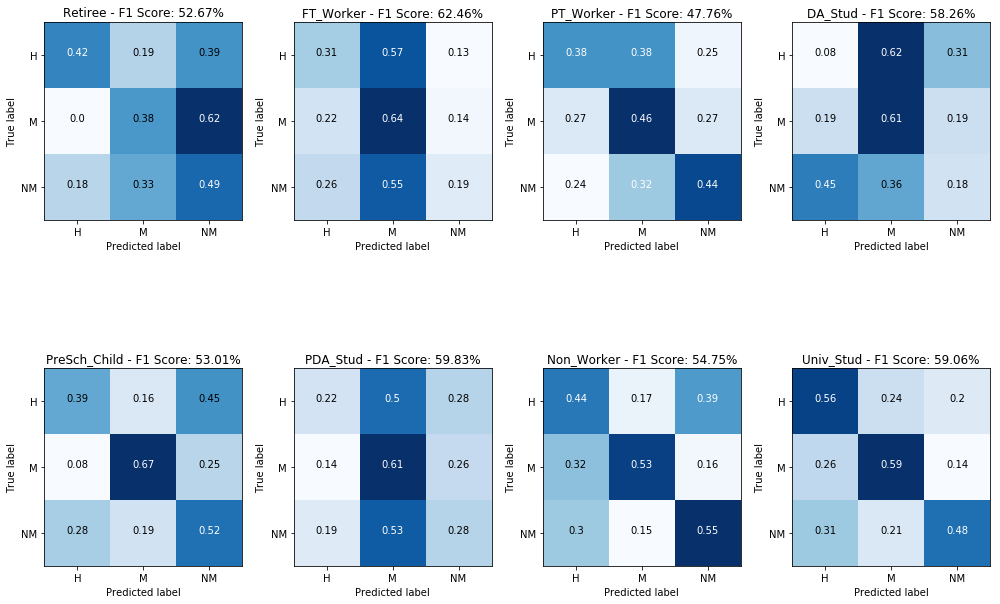

In [110]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for person_type, ax in zip(features.PERTYPE.unique(), axes):
    Y_pred = globals()['mlp_model_%s' % person_type].predict(globals()['X_test_%s' % person_type])
    cm = confusion_matrix(globals()['Y_test_%s' % person_type], Y_pred)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(person_type + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(globals()['Y_test_%s' % person_type], Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##### Gradient Boosting

In [114]:
# Find optimal max depth parameter
param_grid = {'max_depth': np.linspace(5,30,15)}
gbc = GBC(random_state=123, n_estimators=10)
for person_type in features.PERTYPE.unique():
    globals()['gbc_model_%s' % person_type] = GridSearchCV(gbc, param_grid, scoring=f1_scorer)
    globals()['gbc_model_%s' % person_type].fit(globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type])
    print (person_type + ' {}'.format(globals()['gbc_model_%s' % person_type].best_params_))

Retiree {'max_depth': 8.5714285714285712}
FT_Worker {'max_depth': 12.142857142857142}
PT_Worker {'max_depth': 10.357142857142858}
DA_Stud {'max_depth': 8.5714285714285712}
PreSch_Child {'max_depth': 6.7857142857142856}
PDA_Stud {'max_depth': 10.357142857142858}
Non_Worker {'max_depth': 13.928571428571429}
Univ_Stud {'max_depth': 8.5714285714285712}


In [115]:
# Cross validate using best parameters
avg_acc = []
for person_type in features.PERTYPE.unique():
    for i in range(100,125):
        X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                      globals()['Y_%s' % person_type], \
                                                                      test_size=0.33, random_state=i, \
                                                            stratify=globals()['Y_%s' % person_type])

        Y_pred = globals()['gbc_model_%s' % person_type].predict(X_test)
        avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print (person_type + " F1 Score: {}%".format(np.mean(avg_acc)*100))

Retiree F1 Score: 77.09257712083385%
FT_Worker F1 Score: 83.16219801812595%
PT_Worker F1 Score: 83.45066354537657%
DA_Stud F1 Score: 84.68213336339386%
PreSch_Child F1 Score: 81.5635843216859%
PDA_Stud F1 Score: 82.8027519664672%
Non_Worker F1 Score: 82.843504150293%
Univ_Stud F1 Score: 83.05532839923605%


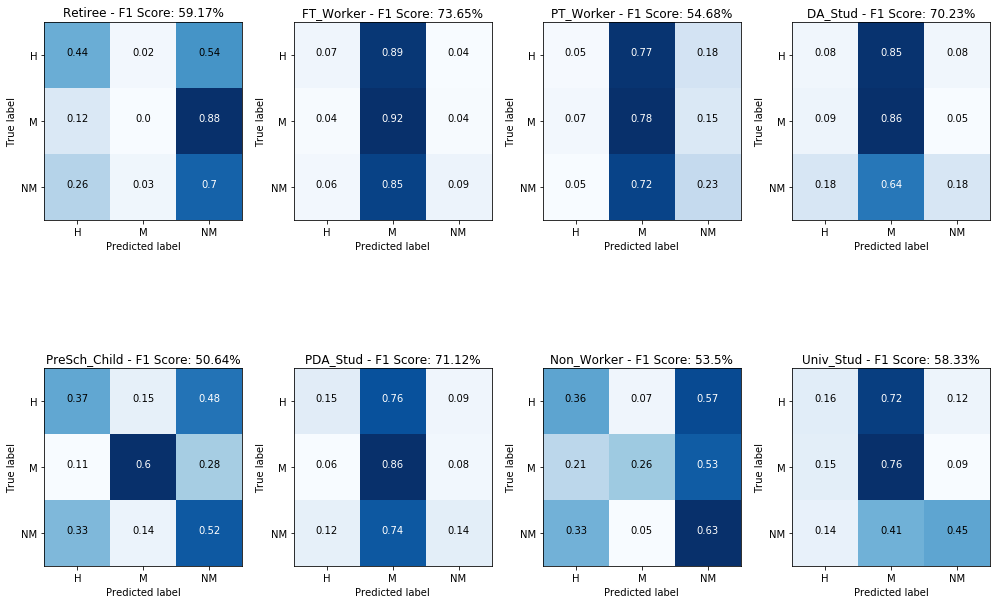

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for person_type, ax in zip(features.PERTYPE.unique(), axes):
    Y_pred = globals()['gbc_model_%s' % person_type].predict(globals()['X_test_%s' % person_type])
    cm = confusion_matrix(globals()['Y_test_%s' % person_type], Y_pred)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(person_type + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(globals()['Y_test_%s' % person_type], Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##### Support Vector Machine

In [118]:
# Find optimal max depth parameter
param_grid = {'C': [.01, .1, 1, 10], 'gamma': [.01, .1, 1, 10]}
svc = SVC(random_state=123)
for person_type in features.PERTYPE.unique():
    globals()['svc_model_%s' % person_type] = GridSearchCV(svc, param_grid, scoring=f1_scorer)
    globals()['svc_model_%s' % person_type].fit(globals()['X_train_res_%s' % person_type], globals()['Y_train_res_%s' % person_type])
    print (person_type + ' {}'.format(globals()['svc_model_%s' % person_type].best_params_))

Retiree {'C': 10, 'gamma': 1}
FT_Worker {'C': 10, 'gamma': 1}
PT_Worker {'C': 10, 'gamma': 1}
DA_Stud {'C': 1, 'gamma': 1}
PreSch_Child {'C': 1, 'gamma': 0.1}
PDA_Stud {'C': 10, 'gamma': 1}
Non_Worker {'C': 1, 'gamma': 1}
Univ_Stud {'C': 10, 'gamma': 0.1}


In [119]:
# Cross validate using best parameters
avg_acc = []
for person_type in features.PERTYPE.unique():
    for i in range(100,125):
        X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                      globals()['Y_%s' % person_type], \
                                                                      test_size=0.33, random_state=i, \
                                                            stratify=globals()['Y_%s' % person_type])

        Y_pred = globals()['svc_model_%s' % person_type].predict(X_test)
        avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print (person_type + " F1 Score: {}%".format(np.mean(avg_acc)*100))

Retiree F1 Score: 70.73790719611941%
FT_Worker F1 Score: 81.95895411115332%
PT_Worker F1 Score: 84.13772992293713%
DA_Stud F1 Score: 84.72172860550981%
PreSch_Child F1 Score: 79.27732522015702%
PDA_Stud F1 Score: 80.3218971808329%
Non_Worker F1 Score: 79.24218233251067%
Univ_Stud F1 Score: 79.13088083803402%


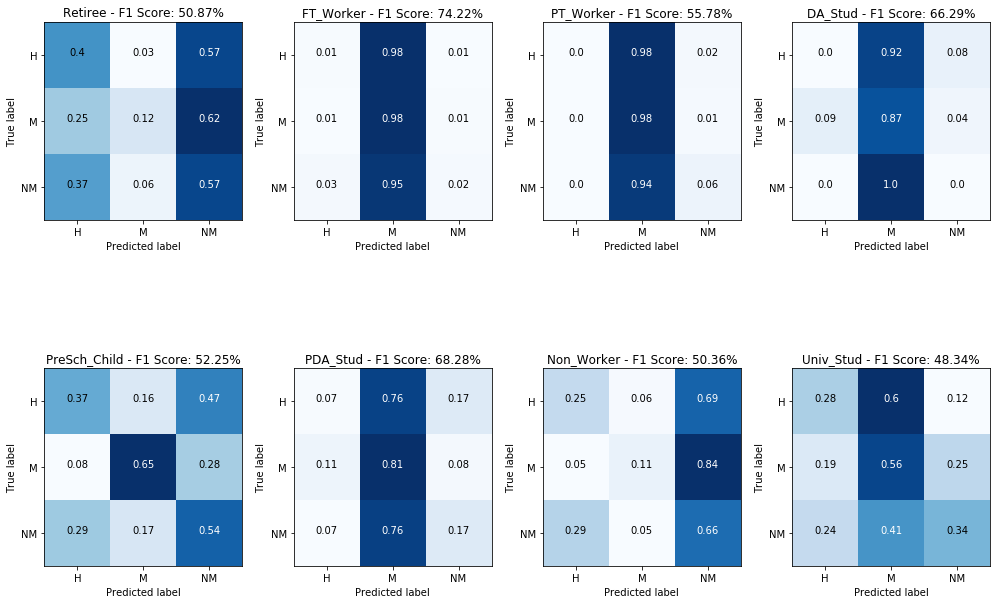

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,14))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for person_type, ax in zip(features.PERTYPE.unique(), axes):
    Y_pred = globals()['svc_model_%s' % person_type].predict(globals()['X_test_%s' % person_type])
    cm = confusion_matrix(globals()['Y_test_%s' % person_type], Y_pred)
    np.set_printoptions(precision=2)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(person_type + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(globals()['Y_test_%s' % person_type], Y_pred, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

#### Compare All Classifiers on Entire Dataset

In [129]:
# Cross validate using best parameters
for model in ['dt', 'rf', 'mlp', 'gbc', 'svc']:
    avg_acc = []
    for person_type in features.PERTYPE.unique():
        for i in range(100,125):
            X_train, X_test, Y_train, Y_test = train_test_split(globals()['X_%s' % person_type], \
                                                                          globals()['Y_%s' % person_type], \
                                                                          test_size=0.33, random_state=i, \
                                                                stratify=globals()['Y_%s' % person_type])

            Y_pred = globals()['%s_model_%s' % (model, person_type)].predict(X_test)
            avg_acc.append(f1_score(Y_test, Y_pred, average='weighted'))
    print ("{} F1 Score: {}%".format(model, np.mean(avg_acc)*100))

dt F1 Score: 79.75998822084152%
rf F1 Score: 84.38050785217732%
mlp F1 Score: 60.659948723998404%
gbc F1 Score: 83.05532839923605%
svc F1 Score: 79.13088083803402%


#### Save Model

In [133]:
for person_type in features.PERTYPE.unique():
    joblib.dump(globals()['gbc_model_%s' % person_type], 'processed_data/gbc_model_{}.pkl'.format(person_type))
    joblib.dump(globals()['mlp_model_%s' % person_type], 'processed_data/mlp_model_{}.pkl'.format(person_type))
    joblib.dump(globals()['rf_model_%s' % person_type], 'processed_data/rf_model_{}.pkl'.format(person_type))
    joblib.dump(globals()['dt_model_%s' % person_type], 'processed_data/dt_model_{}.pkl'.format(person_type))
    joblib.dump(globals()['svc_model_%s' % person_type], 'processed_data/svc_model_{}.pkl'.format(person_type))


#### Load Model

In [16]:
# Save Best Classifier and Scaler
for person_type in features.PERTYPE.unique():
    globals()['gbc_model_%s' % person_type] = joblib.load('processed_data/gbc_model_{}.pkl'.format(person_type))
    globals()['mlp_model_%s' % person_type] = joblib.load('processed_data/mlp_model_{}.pkl'.format(person_type))
    globals()['rf_model_%s' % person_type] = joblib.load('processed_data/rf_model_{}.pkl'.format(person_type))
    globals()['dt_model_%s' % person_type] = joblib.load('processed_data/dt_model_{}.pkl'.format(person_type))
    globals()['svc_model_%s' % person_type] = joblib.load('processed_data/svc_model_{}.pkl'.format(person_type))

#### Predict Probabilities For Each Record

In [19]:
# Split featurespace by person type
features_FT_Worker = features[features['PERTYPE'] == 'FT_Worker']
features_PT_Worker = features[features['PERTYPE'] == 'PT_Worker']
features_Univ_Stud = features[features['PERTYPE'] == 'Univ_Stud']
features_Non_Worker = features[features['PERTYPE'] == 'Non_Worker']
features_Retiree = features[features['PERTYPE'] == 'Retiree']
features_DA_Stud = features[features['PERTYPE'] == 'DA_Stud']
features_PDA_Stud = features[features['PERTYPE'] == 'PDA_Stud']
features_PreSch_Child = features[features['PERTYPE'] == 'PreSch_Child']

idap_processed = pd.DataFrame()
for person_type in features.PERTYPE.unique():
    X = globals()['features_%s' % person_type].drop(['SAMPN_x', 'PERNO_x', 'IDAP'], axis=1)
    X = pd.get_dummies(X)
    probabilities = globals()['rf_model_%s' % person_type].predict_proba(X)
    globals()['features_%s' % person_type]['H'] = [i[0] for i in probabilities]
    globals()['features_%s' % person_type]['M'] = [i[1] for i in probabilities]
    globals()['features_%s' % person_type]['NM'] = [i[2] for i in probabilities]
    
    predictions = globals()['rf_model_%s' % person_type].predict(X)
    globals()['features_%s' % person_type]['PREDICTION'] = predictions
    idap_processed = idap_processed.append(globals()['features_%s' % person_type])

In [20]:
idap_processed.head(10)

,SAMPN_x,PERNO_x,GENDER,PERTYPE,AGE,IDAP,CAR_SUFF,HINCCAT1,EDUCA,JOBS,JOBTYPE,ACCESSIBILITY,DIST,H,M,NM,PREDICTION
0,11002042,1,Female,Retiree,71,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,13.659632,0.0,0.040000,0.000000,0.960000,NM
20,11017006,1,Male,Retiree,69,H,More Cars than Workers,"$50,000 to $74,999",Less than Bachelors,No Job,No Job Type,13.635099,0.0,0.609401,0.000000,0.390599,H
21,11017006,2,Female,Retiree,67,H,More Cars than Workers,"$50,000 to $74,999",Less than Bachelors,No Job,No Job Type,13.635099,0.0,0.326772,0.000000,0.673228,NM
23,11017229,2,Female,Retiree,81,H,More Cars than Workers,"$50,000 to $74,999",Less than Bachelors,No Job,No Job Type,13.437629,0.0,0.974684,0.000000,0.025316,H
45,11038445,1,Female,Retiree,75,NM,More Cars than Workers,"$49,999 or less",Less than Bachelors,No Job,No Job Type,12.741757,0.0,0.370967,0.002496,0.626536,NM
48,11038913,2,Female,Retiree,68,NM,More Cars than Workers,"$50,000 to $74,999",Less than Bachelors,No Job,No Job Type,12.682002,0.0,0.685548,0.000000,0.314452,H
50,11038968,1,Female,Retiree,77,H,More Cars than Workers,"$49,999 or less",Less than Bachelors,No Job,No Job Type,12.904312,0.0,0.588385,0.000250,0.411365,H
51,11038968,2,Male,Retiree,83,H,More Cars than Workers,"$49,999 or less",Less than Bachelors,No Job,No Job Type,12.904312,0.0,0.690755,0.171673,0.137572,H
58,11040753,1,Female,Retiree,74,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,12.728837,0.0,0.280000,0.000000,0.720000,NM
59,11040753,2,Male,Retiree,76,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,12.728837,0.0,0.020000,0.000000,0.980000,NM


In [21]:
idap_processed.sort_index(inplace=True)

idap_processed.rename(columns={'SAMPN_x': 'SAMPN', 'PERNO_x': 'PERNO'}, inplace=True)
idap_processed.set_index(['SAMPN'], inplace=True)
idap_processed

,PERNO,GENDER,PERTYPE,AGE,IDAP,CAR_SUFF,HINCCAT1,EDUCA,JOBS,JOBTYPE,ACCESSIBILITY,DIST,H,M,NM,PREDICTION
SAMPN,,,,,,,,,,,,,,,,
11002042,1,Female,Retiree,71,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,13.659632,0.00,0.040000,0.000000,0.960000,NM
11003319,1,Male,FT_Worker,57,M,More Cars than Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.652378,3.99,0.020000,0.980000,0.000000,M
11003319,2,Female,PT_Worker,54,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,One Job,Education,13.652378,1.65,0.003684,0.808619,0.187697,M
11003319,3,Male,DA_Stud,19,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,More than One Job,Retail,13.652378,1.36,0.040000,0.920000,0.040000,M
11003959,1,Male,FT_Worker,40,M,Cars Equals to Workers,"$49,999 or less",Bachelors or Higher Degree,One Job,Retail,13.562480,16.54,0.000000,0.940000,0.060000,M
11006984,1,Female,FT_Worker,50,M,Cars Equals to Workers,"$75,000 or more",Less than Bachelors,One Job,MORPC INDUS=80,13.524383,0.54,0.200000,0.400000,0.400000,M
11006984,2,Male,FT_Worker,52,M,Cars Equals to Workers,"$75,000 or more",Less than Bachelors,One Job,"Transportation, Utilities and Warehousing",13.524383,2.52,0.020000,0.940000,0.040000,M
11007629,1,Male,FT_Worker,33,M,Cars Equals to Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.630253,12.72,0.060000,0.920000,0.020000,M
11007629,2,Female,FT_Worker,43,M,Cars Equals to Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.630253,3.20,0.100000,0.680000,0.220000,M


F1 Score:  0.870682815333



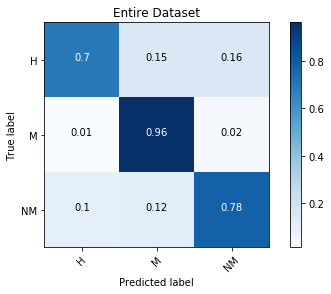

In [22]:
cnf_matrix = confusion_matrix(idap_processed['IDAP'], idap_processed['PREDICTION'])
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(idap_processed['IDAP'], idap_processed['PREDICTION'], average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Entire Dataset')

F1 Score:  0.676076573759



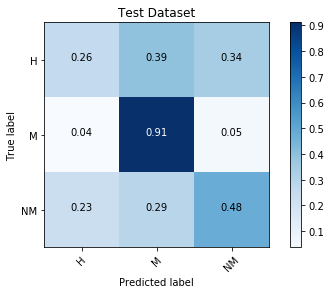

In [25]:
Y_prob_all = []
Y_test_all = []
Y_pred_all = []
probs = [idap_processed['H'].mean(), idap_processed['M'].mean(), idap_processed['NM'].mean()]
for person_type in features.PERTYPE.unique():
    X = globals()['X_test_%s' % person_type]
    
    Y_test_all.extend(globals()['Y_test_%s' % person_type])
    
    probabilities = globals()['rf_model_%s' % person_type].predict_proba(X)
    Y_prob_all.extend(probabilities)
    predictions = globals()['rf_model_%s' % person_type].predict(X)
    Y_pred_all.extend(predictions)ss

cnf_matrix = confusion_matrix(Y_test_all, Y_pred_all)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test_all, Y_pred_all, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

In [26]:
# Output processed IDAP data to csv
idap_processed.to_csv('processed_data/IDAP_processed.csv')

### Train one Model for Entire Dataset

In [165]:
X = pd.get_dummies(features.drop(['SAMPN_x', 'PERNO_x', 'IDAP'], axis=1))
Y = features['IDAP']

In [166]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [167]:
# Upsample to balance out classes
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
### NEED TO FIX CATEGORICAL FEATURES TO INT ###

In [168]:
param_grid = {'max_depth': np.linspace(5,50,20), 'criterion': ['gini', 'entropy']}
rfc = RFC(random_state=123, n_jobs=-1, n_estimators=50)
rfc_model_full = GridSearchCV(rfc, param_grid)
rfc_model_full.fit(X_train_res, Y_train_res)
rfc_model_full.best_params_

{'criterion': 'entropy', 'max_depth': 42.89473684210526}

In [169]:
# Cross validate using best parameters
avg_acc = []
for i in range(100,125):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.33, random_state=i, stratify=Y)
    Y_pred1 = rfc_model_full.predict(X_test1)
    avg_acc.append(f1_score(Y_test1, Y_pred1, average='weighted'))
print ("F1 Score: {}%".format(np.mean(avg_acc)*100))

F1 Score: 90.99398352787647%


F1 Score:  0.909557097619


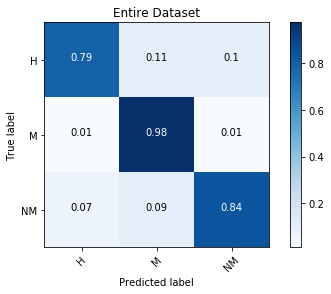

In [170]:
Y_pred = rfc_model_full.predict(X)
cnf_matrix = confusion_matrix(idap_processed['IDAP'], Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(idap_processed['IDAP'], Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Entire Dataset')

F1 Score:  0.691095330391


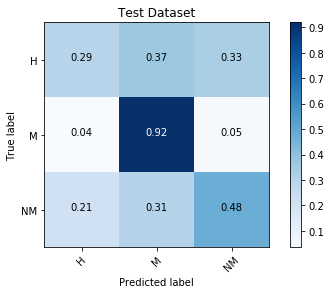

In [171]:
Y_pred = rfc_model_full.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_pred)
classes = ['H', 'M', 'NM']
print ('F1 Score: ',f1_score(Y_test, Y_pred, average='weighted'))
plot_confusion_matrix(cnf_matrix, classes, normalize=True, title='Test Dataset')

In [179]:
random_forest_full = RFC(criterion=rfc_model_full.best_params_['criterion'], max_depth=rfc_model_full.best_params_['max_depth'])
random_forest_full.fit(X_train_res, Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=42.89473684210526, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [185]:
headers = ["name", "score"]
values = sorted(zip(X_train_res.columns, random_forest_full.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                                                               score
ACCESSIBILITY                                                0.198275
AGE                                                          0.18242
DIST                                                         0.141999
CAR_SUFF_Cars Equals to Workers                              0.0310224
PERTYPE_FT_Worker                                            0.0294938
JOBTYPE_No Job Type                                          0.0294118
HINCCAT1_$49,999 or less                                     0.0273717
GENDER_Female                                                0.0262364
HINCCAT1_$50,000 to $74,999                                  0.025881
HINCCAT1_$75,000 or more                                     0.0251508
PERTYPE_Non_Worker                                           0.0230996
CAR_SUFF_More Cars than Workers                              0.0225414
GENDER_Male                                                  0.0224829
JOBS_One 